# Discovering Fake News using Python and Machine Learning

During this exercise, we will attempt to create a machine learning model capable of detecting fake news.

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import re
import string

## Data Loading and Preparation

In [3]:
somenews = pd.read_csv('somenews.csv')

In [4]:
somenews.shape

(6335, 4)

In [5]:
somenews.head(6)

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE


Machines learn better with num values than with strings so first we'll add a new class 'class' with 0 for fake and 1 for real

In [6]:
somenews['class'] = [0 if value == 'FAKE' else 1 for value in somenews['label']]

In [7]:
somenews.head(6)

,Unnamed: 0,title,text,label,class
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE,0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL,1
5,6903,"Tehran, USA","\nI’m not an immigrant, but my grandparents ...",FAKE,0


Now we don't need label column anymore, and the first column has unique number for each rows i don't think it will be useful for the training.
So we will delete the first column "Unnamed" and the fourth column "label"

In [8]:
somenews.columns

Index(['Unnamed: 0', 'title', 'text', 'label', 'class'], dtype='object')

In [9]:
data = somenews.drop(['Unnamed: 0', 'label'], axis=1)

In [10]:
data.head(5)

,title,text,class
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


In [11]:
data.columns

Index(['title', 'text', 'class'], dtype='object')

<Axes: xlabel='class', ylabel='count'>

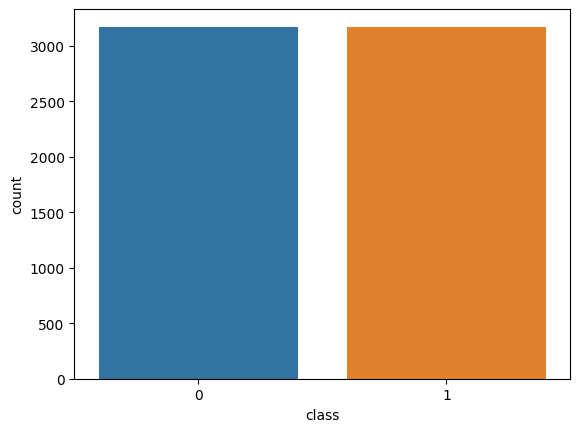

In [12]:
import seaborn as sns
sns.countplot(x='class', data=data)

We have an equal or almost equal repartition of fake news and real news

### Text Preprocessing 

For improved machine learning model training, it is advisable to make some modifications to the text. For example :   
Convert all the letters to lowercase;  
remove punctuation, special characters, and HTML tags, links;  


In [13]:
def txtpreprocess(text):
    # lowercase
    text = text.lower()
    # remove special characters (non-alphanumeric)
    text = re.sub("\\W", " ", text)
    # remove square brackets and their contents
    text = re.sub('\[.*?]', '', text)
    # remove links
    text = re.sub('https?://\S|www\.\S+', '', text)
    # remove tags
    text = re.sub('<.*?>+', '', text)
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # remove newline characters,
    text = re.sub('\n', '', text)
    # remove alphanumeric strings with digits
    text = re.sub('\w*\d\w*', '', text)
    
    return text 

In [14]:
# Test Function
text = data['text'][0]
print("Original Text :")
print(text)

Original Text :
Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. 
In the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI. 
The word “unprecedented” has been thrown around so often this election that it ought to be retired. But it’s still unprecedented for the nominee of a major political party to go war with the FBI. 
But that’s exactly what Hillary and her people have done. Coma patients just waking up now and watching an hour of CNN from their hospital beds would assume that FBI Director James Comey is Hillary’s opponent in this election. 
The FBI is under attack by everyone from Obama to CNN. Hillary’s people have circulated a letter attacking Comey. There are currently more media hit pieces lambasting him than targeting Trump. It wouldn’t be too surprising if the Clintons or their allies were to start running attack ads against the FBI. 
The FBI’s leadership is being warned that

In [15]:
print("Preprocessed Text :")
print(txtpreprocess(text))

Preprocessed Text :
daniel greenfield  a shillman journalism fellow at the freedom center  is a new york writer focusing on radical islam   in the final stretch of the election  hillary rodham clinton has gone to war with the fbi   the word  unprecedented  has been thrown around so often this election that it ought to be retired  but it s still unprecedented for the nominee of a major political party to go war with the fbi   but that s exactly what hillary and her people have done  coma patients just waking up now and watching an hour of cnn from their hospital beds would assume that fbi director james comey is hillary s opponent in this election   the fbi is under attack by everyone from obama to cnn  hillary s people have circulated a letter attacking comey  there are currently more media hit pieces lambasting him than targeting trump  it wouldn t be too surprising if the clintons or their allies were to start running attack ads against the fbi   the fbi s leadership is being warned 

In [16]:
data['text'] = data['text'].apply(txtpreprocess)
data['title'] = data['title'].apply(txtpreprocess)

## Model Training

#### Data splitting

In [17]:
#X = data['title'].values + ' ' + data['text'].values
X = data['text'].values
y = data['class'].values
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Text Vectorization 

We'll use TfidfVectorizer to convert our datas of textual documents into a numeric matrix of TF-IDF vectors. It calculates the Term Frequency-Inverse Document Frequency (TF-IDF) values for each term in the documents.  
I used also the CountVectorizer that simply counts the number of occurrences of each word (or token) in each document.  

In [72]:
'''
from sklearn.feature_extraction.text import TfidfVectorizer
vectorization = TfidfVectorizer()
'''
from sklearn.feature_extraction.text import CountVectorizer
vectorization = CountVectorizer()
#'''
xv_train = vectorization.fit_transform(x_train)
xv_test = vectorization.transform(x_test)

### Algorithms choice

We have here a classification problem : the news are either REAL or FAKE.  
There are a lot of algorithms that can used, so i tried to look for the most used. After some research, i found Naive Bayes, Logistic Regression and Random Forests.

##### Logistic Regression 

In [73]:
from sklearn.linear_model import LogisticRegression

LogReg = LogisticRegression(max_iter=500)
LogReg.fit(xv_train, y_train)

LogisticRegression(max_iter=500)

In [74]:
pred_LogReg = LogReg.predict(xv_test)
LogReg.score(xv_test, y_test)

0.9329123914759274

In [75]:
print(classification_report(y_test, pred_LogReg))

              precision    recall  f1-score   support

           0       0.93      0.94      0.93       638
           1       0.94      0.92      0.93       629

    accuracy                           0.93      1267
   macro avg       0.93      0.93      0.93      1267
weighted avg       0.93      0.93      0.93      1267



#### Random Forest

In [76]:
from sklearn.ensemble import RandomForestClassifier

RandomForestModel = RandomForestClassifier()
RandomForestModel.fit(xv_train, y_train)

RandomForestClassifier()

In [77]:
pred_RandomForest = RandomForestModel.predict(xv_test)
RandomForestModel.score(xv_test, y_test)

0.8958168902920284

In [78]:
print(classification_report(y_test, pred_RandomForest))

              precision    recall  f1-score   support

           0       0.89      0.90      0.90       638
           1       0.90      0.89      0.89       629

    accuracy                           0.90      1267
   macro avg       0.90      0.90      0.90      1267
weighted avg       0.90      0.90      0.90      1267



#### SVM

In [79]:
from sklearn import svm

svmModel = svm.SVC()
svmModel.fit(xv_train, y_train)

SVC()

In [80]:
pred_svm = svmModel.predict(xv_test)
svmModel.score(xv_test, y_test)

0.8531965272296764

In [81]:
print(classification_report(y_test, pred_svm))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86       638
           1       0.92      0.77      0.84       629

    accuracy                           0.85      1267
   macro avg       0.86      0.85      0.85      1267
weighted avg       0.86      0.85      0.85      1267



## Exportation

In [82]:
import pickle

'''

pickle.dump(LogReg, open('LogisticRegression_TfidfVectorizer.pkl','wb'))
pickle.dump(RandomForestModel, open('RandomForest_TfidfVectorizer.pkl','wb'))
pickle.dump(svmModel, open('SVM_TfidfVectorizer.pkl','wb'))

'''

pickle.dump(LogReg, open('LogisticRegression_CountVectorizer.pkl','wb'))
pickle.dump(RandomForestModel, open('RandomForest_CountVectorizer.pkl','wb'))
pickle.dump(svmModel, open('SVM_CountVectorizer.pkl','wb'))

#'''

## Conclusion 

After several training sessions, I have deduced the following conclusions:  
Training is more effective when increasing the amount of data, but this also means reducing the amount of test data, which affects the reliability of the results.  
Regarding the two vectorizers, CountVectorizer improves the performance of Logistic Regression models, while TfidfVectorizer enhances the performance of Random Forest and SVM.  
Adding titles column to the data doesn't necessarily improve the performance of the models. In the case of Random Forest, there is actually a decrease in the score. As for the other models, the increase in performance is relatively small.

## Adding new datas to the dataset

We'll add new datas to the dataset to improve our models  
The file Face.csv contains fake news and True.csv real news.

In [83]:
Fake = pd.read_csv('Fake.csv')
Real = pd.read_csv('True.csv')

In [84]:
Fake.head(3)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"


In [85]:
Fake.shape

(23481, 4)

In [86]:
Real.head(3)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"


In [87]:
Real.shape

(21417, 4)

We don't need columns subject and date  
And we'll have to add class column

In [88]:
Fake = Fake.drop(['subject', 'date'], axis=1)
Real = Real.drop(['subject', 'date'], axis=1)

In [89]:
Fake['class'] = 0
Real['class'] = 1

Let's do the preprocessing

In [90]:
Fake['text'] = Fake['text'].apply(txtpreprocess)
Fake['title'] = Fake['title'].apply(txtpreprocess)

Real['text'] = Real['text'].apply(txtpreprocess)
Real['title'] = Real['title'].apply(txtpreprocess)

In [91]:
Fake.head(3)

,title,text,class
0,donald trump sends out embarrassing new year ...,donald trump just couldn t wish all americans ...,0
1,drunk bragging trump staffer started russian ...,house intelligence committee chairman devin nu...,0
2,sheriff david clarke becomes an internet joke...,on friday it was revealed that former milwauk...,0


In [92]:
Real.head(3)

,title,text,class
0,as u s budget fight looms republicans flip t...,washington reuters the head of a conservat...,1
1,u s military to accept transgender recruits o...,washington reuters transgender people will...,1
2,senior u s republican senator let mr muell...,washington reuters the special counsel inv...,1


Let's save some datas for testing

In [93]:
data_for_test = pd.concat([Fake.tail(10),Real.tail(10)], ignore_index=True)
data_for_test = data_for_test.reindex(np.random.permutation(data_for_test.index))
data_for_test.reset_index(drop=True, inplace=True)

In [94]:
data_for_test.head(5)

,title,text,class
0,minsk cultural hub becomes haven from authorities,minsk reuters in the shadow of disused sov...,1
1,u s north korea clash at u n forum over nuc...,geneva reuters north korea and the united ...,1
2,hashtag hell the fake left,by dady chery and gilbert mercierall writers ...,0
3,hillary clinton israel first and no peace ...,robert fantina counterpunchalthough the united...,0
4,fully committed nato backs new u s approach...,brussels reuters nato allies on tuesday we...,1


In [95]:
for i in range(0,10,1):
    Fake.drop([23480 - i], axis = 0, inplace=True)
    Real.drop([21416 - i], axis = 0, inplace=True)

In [96]:
Real.shape, Fake.shape

((21407, 3), (23471, 3))

### Merging Fake and Real with data to create a new dataset

In [97]:
new_data = pd.concat([data,Fake,Real], ignore_index=True)
new_data = new_data.reindex(np.random.permutation(new_data.index))
new_data.reset_index(drop=True, inplace=True)

In [98]:
new_data.head(10)

,title,text,class
0,life if you love enamel pins you ll love thi...,email if you can t get enough enamel pins the...,0
1,breaking judge ambushed outside courthouse sh...,jefferson county judge joseph j bruzzese jr ...,0
2,u of chicago admissions blames trump for chica...,the university of chicago s admissions office ...,0
3,pentagon says diplomatic tension with turkey n...,washington reuters a diplomatic dispute be...,1
4,u n chief calls for united appropriate acti...,united nations reuters united nations secr...,1
5,reince priebus does weird balancing act regar...,donald trump s recent talk of a rigged electi...,0
6,you re fired why the white house just fired a...,national security council aide craig deare was...,0
7,facebook user arrested for offensive posts a...,only months ago obama s attorney general lor...,0
8,internet slams trump over mother s day women ...,this morning our commander in chief wished hap...,0
9,trump to black voters you re poor your scho...,donald trump has once again showed why he will...,0


In [99]:
new_data.shape

(51213, 3)

We now have a lot more data

### Data splitting

In [100]:
#X = data['title'].values + ' ' + data['text'].values
X = new_data['text'].values
Y = new_data['class'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)

### Text Vectorization

In [101]:
'''
from sklearn.feature_extraction.text import TfidfVectorizer
Vectorization = TfidfVectorizer()
'''
from sklearn.feature_extraction.text import CountVectorizer
Vectorization = CountVectorizer()
#'''
Xv_train = Vectorization.fit_transform(X_train)
Xv_test = Vectorization.transform(X_test)

### Logistic Regression AGAIN

In [102]:
NewLogReg = LogisticRegression(max_iter=1000)
NewLogReg.fit(Xv_train, Y_train)

LogisticRegression(max_iter=1000)

In [103]:
pred_NewLogReg = NewLogReg.predict(Xv_test)
NewLogReg.score(Xv_test, Y_test)

0.9747461598542047

In [104]:
print(classification_report(Y_test, pred_NewLogReg))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3946
           1       0.98      0.97      0.97      3736

    accuracy                           0.97      7682
   macro avg       0.97      0.97      0.97      7682
weighted avg       0.97      0.97      0.97      7682



### Random Forest AGAIN

In [105]:
NewRandomForestModel = RandomForestClassifier()
NewRandomForestModel.fit(Xv_train, Y_train)

RandomForestClassifier()

In [106]:
pred_NewRandomForest = NewRandomForestModel.predict(Xv_test)
NewRandomForestModel.score(Xv_test, Y_test)

0.9575631346003645

In [107]:
print(classification_report(Y_test, pred_NewRandomForest))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      3946
           1       0.97      0.94      0.96      3736

    accuracy                           0.96      7682
   macro avg       0.96      0.96      0.96      7682
weighted avg       0.96      0.96      0.96      7682



### SVM AGAIN

In [108]:
NewSvmModel = svm.SVC()
NewSvmModel.fit(Xv_train, Y_train)

SVC()

In [109]:
pred_NewSVM = NewSvmModel.predict(Xv_test)
NewSvmModel.score(Xv_test, Y_test)

0.9635511585524603

In [110]:
print(classification_report(Y_test, pred_NewSVM))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      3946
           1       0.98      0.94      0.96      3736

    accuracy                           0.96      7682
   macro avg       0.96      0.96      0.96      7682
weighted avg       0.96      0.96      0.96      7682



### Exportation

In [111]:
'''

pickle.dump(NewLogReg, open('N_LogisticRegression_TfidfVectorizer.pkl','wb'))
pickle.dump(NewRandomForestModel, open('N_RandomForest_TfidfVectorizer.pkl','wb'))
pickle.dump(NewSvmModel, open('N_SVM_TfidfVectorizer.pkl','wb'))

'''

pickle.dump(NewLogReg, open('N_LogisticRegression_CountVectorizer.pkl','wb'))
pickle.dump(NewRandomForestModel, open('N_RandomForest_CountVectorizer.pkl','wb'))
pickle.dump(NewSvmModel, open('N_SVM_CountVectorizer.pkl','wb'))

#'''

## Let's do some tests

### Import saved models

In [ ]:
import pickle

#### Logistic Regression 

In [112]:
#'''
with open('LogisticRegression_CountVectorizer.pkl', 'rb') as file:
    LR_CV_Model = pickle.load(file)
#'''
#'''
with open('LogisticRegression_TfidfVectorizer.pkl', 'rb') as file:
    LR_TV_Model = pickle.load(file)
#'''
with open('N_LogisticRegression_CountVectorizer.pkl', 'rb') as file:
    LR_N_CV_Model = pickle.load(file)
#'''
#'''
with open('N_LogisticRegression_TfidfVectorizer.pkl', 'rb') as file:
    LR_N_TV_Model = pickle.load(file)
#'''

#### Random Forest

In [113]:
#'''
with open('RandomForest_CountVectorizer.pkl', 'rb') as file:
    RF_CV_Model = pickle.load(file)
#'''
#'''
with open('RandomForest_TfidfVectorizer.pkl', 'rb') as file:
    RF_TV_Model = pickle.load(file)
#'''
#'''
with open('N_RandomForest_CountVectorizer.pkl', 'rb') as file:
    RF_N_CV_Model = pickle.load(file)
#'''
#'''
with open('N_RandomForest_TfidfVectorizer.pkl', 'rb') as file:
    RF_N_TV_Model = pickle.load(file)
#'''

#### SVM

In [114]:
#'''
with open('SVM_CountVectorizer.pkl', 'rb') as file:
    SVM_CV_Model = pickle.load(file)
#'''
#'''
with open('SVM_TfidfVectorizer.pkl', 'rb') as file:
    SVM_TV_Model = pickle.load(file)
#'''
#'''
with open('N_SVM_CountVectorizer.pkl', 'rb') as file:
    SVM_N_CV_Model = pickle.load(file)
#'''
#'''
with open('N_SVM_TfidfVectorizer.pkl', 'rb') as file:
    SVM_N_TV_Model = pickle.load(file)
#'''

In [63]:
def isFake(n):
    if n == 0:
        return "It is a fake news"
    elif n == 1:
        return "It is not a fake news"

In [115]:
def testing(news, val):
    print("This news is fake" if val == 0 else "This news is real")
    news = txtpreprocess(news)
    newsv = vectorization.transform([news])
    newsV = Vectorization.transform([news])
    
    '''
    pred_lr = LR_TV_Model.predict(newsv)
    pred_LR = LR_N_TV_Model.predict(newsV)
    #'''
    pred_lr = LR_CV_Model.predict(newsv)
    pred_LR = LR_N_CV_Model.predict(newsV)
    #'''
    
    print("Logistic Regression:")
    print("  Old prediction: {}".format(isFake(pred_lr[0])))
    print("  New prediction: {}".format(isFake(pred_LR[0])))
    
    '''
    pred_rf = RF_TV_Model.predict(newsv)
    pred_RF = RF_N_TV_Model.predict(newsV)
    #'''
    pred_rf = RF_CV_Model.predict(newsv)
    pred_RF = RF_N_CV_Model.predict(newsV)
    #'''
    
    print("Random Forest:")
    print("  Old prediction: {}".format(isFake(pred_rf[0])))
    print("  New prediction: {}".format(isFake(pred_RF[0])))
    
    '''
    pred_svm = SVM_TV_Model.predict(newsv)
    pred_SVM = SVM_N_TV_Model.predict(newsV)
    #'''
    pred_svm = SVM_CV_Model.predict(newsv)
    pred_SVM = SVM_N_CV_Model.predict(newsV)
    #'''
    
    print("SVM:")
    print("  Old prediction: {}".format(isFake(pred_svm[0])))
    print("  New prediction: {}".format(isFake(pred_SVM[0])))

In [116]:
news = data_for_test['text'][1]
val = data_for_test['class'][1]

print(news)

geneva  reuters    north korea and the united states clashed at a u n  forum on tuesday over their military intentions towards one another  with pyongyang s envoy declaring it would  never  put its nuclear deterrent on the negotiating table  japan  well within reach of north korea s missiles  said the world must maintain pressure on the reclusive country to rein in its nuclear and missile programs and now was not the time for a resumption of multi party talks  north korea has pursued its weapons programs in defiance of u n  security council sanctions and ignored all calls  including from major ally china  to stop  prompting a bellicose exchange of rhetoric between the north and the united states  north korea justifies its weapons programs  including its recent threat to fire missiles towards the u s  pacific territory of guam  by pointing to perceived u s  hostility  such as military exercises with south korea this week  u s  disarmament ambassador robert wood told a u n  sponsored con

In [117]:
testing(news, val)

This news is real
Logistic Regression:
  Old prediction: It is a fake news
  New prediction: It is not a fake news
Random Forest:
  Old prediction: It is not a fake news
  New prediction: It is not a fake news
SVM:
  Old prediction: It is not a fake news
  New prediction: It is not a fake news


In [118]:
for i in range(0, 20):
    # data_for_test is created just after loading new datas
    news = data_for_test['text'][i]
    val = data_for_test['class'][i]
    testing(news, val)
    print("\n\n")

This news is real
Logistic Regression:
  Old prediction: It is not a fake news
  New prediction: It is not a fake news
Random Forest:
  Old prediction: It is a fake news
  New prediction: It is not a fake news
SVM:
  Old prediction: It is a fake news
  New prediction: It is not a fake news



This news is real
Logistic Regression:
  Old prediction: It is a fake news
  New prediction: It is not a fake news
Random Forest:
  Old prediction: It is not a fake news
  New prediction: It is not a fake news
SVM:
  Old prediction: It is not a fake news
  New prediction: It is not a fake news



This news is fake
Logistic Regression:
  Old prediction: It is a fake news
  New prediction: It is a fake news
Random Forest:
  Old prediction: It is a fake news
  New prediction: It is a fake news
SVM:
  Old prediction: It is a fake news
  New prediction: It is a fake news



This news is fake
Logistic Regression:
  Old prediction: It is a fake news
  New prediction: It is a fake news
Random Forest:
  Ol

## Observation

On the whole, increasing the data in the dataset has improved the performance of the new models. However, having more data also results in longer training times, especially for the SVM model.  
The most performant models are the SVM trained with a TfidfVectorizer and the Logistic Regression model with a CountVectorizer.